# TOP

In [1]:
!python -m pip freeze

anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.3.0
babel==2.17.0
beautifulsoup4==4.13.4
bleach==6.2.0
certifi==2025.4.26
cffi==1.17.1
charset-normalizer==3.4.2
cmocean==4.0.3
comm==0.2.2
contourpy==1.3.2
cycler==0.12.1
debugpy==1.8.14
decorator==5.2.1
defusedxml==0.7.1
executing==2.2.0
fastjsonschema==2.21.1
flexfrac1d @ git+ssh://git@github.com/sasip-climate/flexfrac1d.git@0402bfb4738b1fa9665290f9e2a6f9ce6e37ae0d
fonttools==4.58.0
fqdn==1.5.1
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
idna==3.10
ipykernel==6.29.5
ipython==9.2.0
ipython_pygments_lexers==1.1.1
ipywidgets==8.1.7
isoduration==20.11.0
itables==2.4.0
jedi==0.19.2
Jinja2==3.1.6
json5==0.12.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2025.4.1
jupyter-events==0.12.0
jupyter-lsp==2.2.5
jupyter_client==8.6.3
jupyter_core==5.8.0
jupyter_server==2.16.0
jupyter_server_terminals==0.5.3
jupyterlab==4.4.3
jupyterlab_pygments==0.3.0
jupyterlab

In [1]:
import cmocean
import cmocean.cm as cmo

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from flexfrac1d.model.model import Ice, Floe, Ocean, DiscreteSpectrum, Domain
from flexfrac1d.lib.att import AttenuationParameterisation
from flexfrac1d.lib.physics import FluidSurfaceHandler
from flexfrac1d.model.frac_handlers import BinaryFracture, BinaryStrainFracture
from flexfrac1d.model.model import 

from lib.lib import (
    make_parameters,
    compute_split,
    compute_dissipation_length,
    threshold_search,
    calc_energy_if_frac,
    colours,
    WIDTH_TWO_COLUMNS,
    WIDTH_SINGLE_COLUMN,
    GR,
)

# Schema

In [3]:
thickness = .5
youngs_modulus = 4e9
ice = Ice(thickness=thickness, youngs_modulus=youngs_modulus)

depth = np.inf
ocean = Ocean()

period = 7
amplitude = .2
phase = -.3
# phase = 2.61
spectrum = DiscreteSpectrum(amplitude, 1 / period, phases=phase)

gravity = 9.8
domain = Domain.from_discrete(gravity, spectrum, ocean)

length = 120
left_edge = 0
floe = Floe(left_edge=left_edge, length=length, ice=ice)
domain.add_floes(floe)
wuf = domain.subdomains[0]

x = np.linspace(0, wuf.length, 400)
along_floe_axis = x + wuf.left_edge
displacement = wuf.displacement(x, an_sol=True)
deflected_floe_bottom = displacement - wuf.wui.ice.draft
deflected_floe_top = displacement + wuf.wui.ice.freeboard

left_margin, right_margin = 15, 15
pre_floe_axis = np.linspace(-left_margin, 0, 100) + wuf.left_edge
_t = np.linspace(0, right_margin, 100)
post_floe_axis = _t + wuf.left_edge + wuf.length
transformed_post_floe_axis = _t + wuf.wui.wavenumbers / domain.fsw.wavenumbers * wuf.length
domain_fsh = FluidSurfaceHandler.from_domain(domain)
pre_floe_surface = domain_fsh.compute(pre_floe_axis)
post_floe_surface = (
    domain_fsh.compute(transformed_post_floe_axis)
    * np.exp(-wuf.wui.attenuations * wuf.length)
)
along_floe_surface = FluidSurfaceHandler.from_wuf(wuf).compute(x)
assert np.allclose(pre_floe_surface[-1] - along_floe_surface[0], 0)
assert np.allclose(along_floe_surface[-1] - post_floe_surface[0], 0)

print(domain.fsw.wavelengths, 2 * np.pi / wuf.wui.wavenumbers)
print(wuf.wui.ice.elastic_length * wuf.wui.wavenumbers)

[76.42620367] [84.3329689]
[0.6121838]


In [24]:
# Serialise data for figure generation

import attrs
import json


# Neither arrays nor complex number can be json-dumped
def clean_dict(ob, func):
    if isinstance(ob, dict):
        return {k: clean_dict(v, func) for k, v in ob.items()}
    else:
        return func(ob)


def flatten_arrays(ob):
    if isinstance(ob, np.ndarray):
        if len(ob) == 1:
            return ob[0]
        else:
            raise NotImplementedError
    return ob


def stringify_complex(ob):
    if isinstance(ob, complex):
        return str(ob)
    return ob

    
schema_dict = {
    "ocean": attrs.asdict(ocean),
    "wuf": attrs.asdict(wuf),
    "wave": (
        {"period": 1/spectrum._freqs, "amplitude": spectrum._amps, "phase": phase}
    ),
    "gravity": gravity,
}
schema_dict = clean_dict(clean_dict(schema_dict, flatten_arrays), stringify_complex)
with open("schema_params.json", "w") as fp:
    json.dump(schema_dict, fp)


np.savez(
    "schematics_results.npz",
    pre_floe_axis=pre_floe_axis,
    along_floe_axis=along_floe_axis,
    post_floe_axis=post_floe_axis,
    pre_floe_surface=pre_floe_surface,
    along_floe_surface=along_floe_surface,
    post_floe_surface=post_floe_surface,
    displacement=displacement,
)

In [4]:
fluid_colour = cmocean.cm.ice(.05)
floe_colour = cmocean.cm.ice(.618)

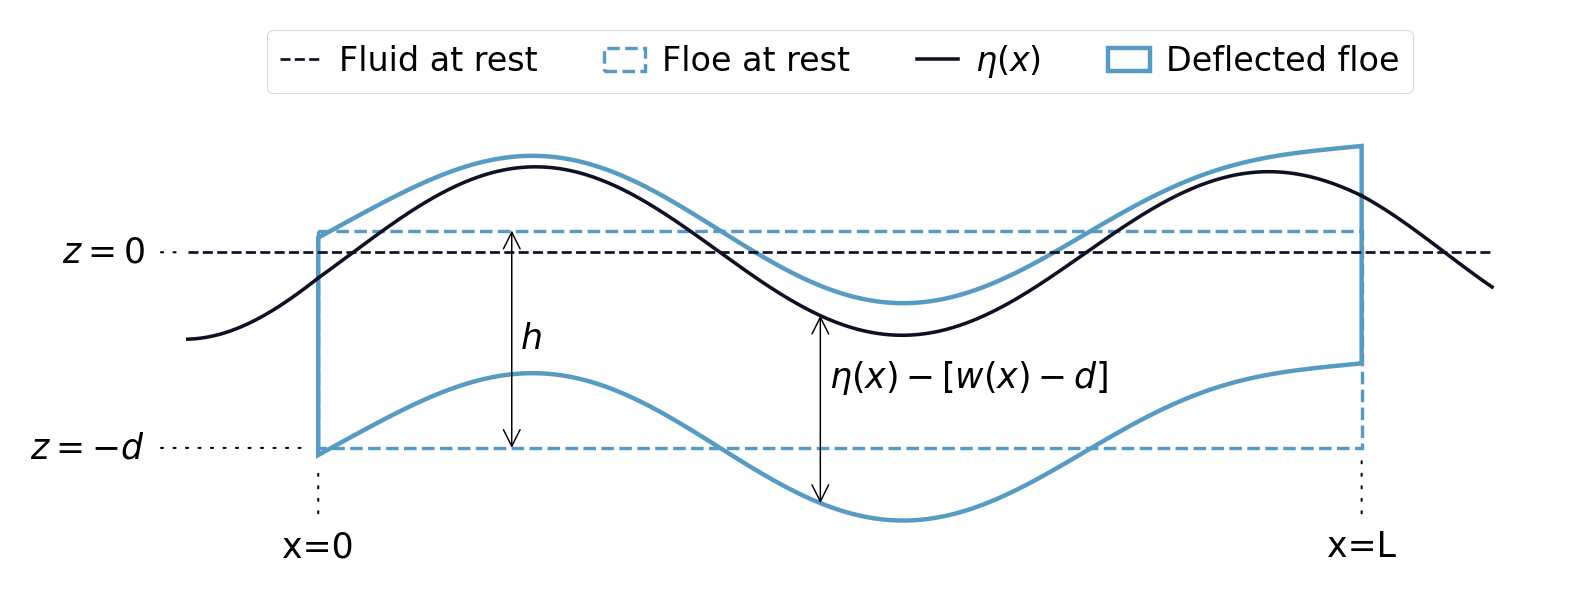

In [5]:
rest_lw = .65
defl_lw = .85
floe_fact = 1.25
fluid_colour = cmocean.cm.ice(.05)
floe_colour = cmocean.cm.ice(.618)
arrow_dict = dict(
    arrowstyle='<->',
    lw=.35,
    mutation_scale=10,
    shrinkA=0,
    shrinkB=0,
)
arrowprops = dict(lw=.5, ls=(0, (1, 5)), arrowstyle="-")
text_dict = dict(
    fontsize="small",
)

deflected_floe = plt.Polygon(
    np.vstack((
        np.hstack((along_floe_axis, along_floe_axis[::-1])),
        np.hstack((deflected_floe_top, deflected_floe_bottom[::-1]))
    )).T,
    closed=True,
    facecolor="#0000",
    edgecolor=floe_colour,
    lw=defl_lw * floe_fact,
    label="Deflected floe",
)
at_rest_floe = plt.Polygon(
    [
        [along_floe_axis[0], wuf.wui.ice.freeboard],
        [along_floe_axis[-1], wuf.wui.ice.freeboard],
        [along_floe_axis[-1], -wuf.wui.ice.draft],
        [along_floe_axis[0], -wuf.wui.ice.draft],
    ],
    closed=True,
    facecolor="#0000",
    edgecolor=floe_colour,
    ls="--",
    lw=rest_lw * floe_fact,
    label="Floe at rest",
)
idx = 74
thickness_arrow = mpatches.FancyArrowPatch(
    (along_floe_axis[idx], wuf.wui.ice.freeboard),
    (along_floe_axis[idx], -wuf.wui.ice.draft),
    **arrow_dict,
)
length_arrow = mpatches.FancyArrowPatch(
    (along_floe_axis[0], -wuf.wui.ice.draft + .05),
    (along_floe_axis[-1], -wuf.wui.ice.draft + .05),
    **arrow_dict,
)
idx = 192
perturbation_arrow = mpatches.FancyArrowPatch(
    (along_floe_axis[idx], along_floe_surface[idx]),
    (along_floe_axis[idx], deflected_floe_bottom[idx]),
    **arrow_dict,
)

with plt.style.context("seaborn-v0_8-paper"):
    fig, ax = plt.subplots(figsize=(5.4, 2.6), dpi=300)

    ax.plot(
        (pre_floe_axis[0], post_floe_axis[-1]),
        (0, 0),
        c=fluid_colour,
        ls="--",
        lw=rest_lw,
        label="Fluid at rest"
    )
    ax.add_patch(at_rest_floe)

    ax.plot(along_floe_axis, along_floe_surface, lw=defl_lw, c=fluid_colour)
    ax.plot(pre_floe_axis, pre_floe_surface, lw=defl_lw, c=fluid_colour)
    ax.plot(
        post_floe_axis,
        post_floe_surface,
        lw=defl_lw,
        c=fluid_colour,
        label=r"$\eta(x)$",
    )
    ax.add_patch(deflected_floe)
    ax.add_patch(thickness_arrow)
    ax.text(
        thickness_arrow._posA_posB[0][0] + 1,
        (wuf.wui.ice.freeboard - wuf.wui.ice.draft) / 2,
        "$h$",
        horizontalalignment="left",
        verticalalignment="center",
        **text_dict,
    )
    ax.add_patch(perturbation_arrow)
    ax.text(
        perturbation_arrow._posA_posB[0][0] + 1,
        (2 * perturbation_arrow._posA_posB[0][1] + perturbation_arrow._posA_posB[1][1]) / 3,
        r"$\eta(x) - [w(x) - d]$",
        horizontalalignment="left",
        verticalalignment="center",
        **text_dict,
    )

    ax.set_ylim(-.7, .3)
    
    ax.annotate(
        "$z=0$",
        (pre_floe_axis[0], 0,),
        (pre_floe_axis[0] - 5, 0,),
        horizontalalignment="right",
        verticalalignment="center",
        arrowprops=arrowprops,
        **text_dict,
    )
    ax.annotate(
        "$z=-d$",
        (along_floe_axis[0], -wuf.wui.ice.draft),
        (pre_floe_axis[0] - 5, -wuf.wui.ice.draft),
        horizontalalignment="right",
        verticalalignment="center",
        arrowprops=arrowprops,
        **text_dict,
    )
    ax.annotate(
        "x=0",
        (along_floe_axis[0], deflected_floe_bottom[0]),
        (along_floe_axis[0], deflected_floe_bottom.min() - .1),
        horizontalalignment="center",
        verticalalignment="bottom",
        arrowprops=dict(lw=.5, ls=(0, (1, 5)), arrowstyle="-"),
        **text_dict,
    )
    ax.annotate(
        "x=L",
        (along_floe_axis[-1], -wuf.wui.ice.draft),
        (along_floe_axis[-1], deflected_floe_bottom.min() - .1),
        horizontalalignment="center",
        verticalalignment="bottom",
        arrowprops=dict(lw=.5, ls=(0, (1, 5)), arrowstyle="-"),
        **text_dict,
    )

    ax.set_aspect(5e1)
    ax.set_axis_off()

    ax.legend(
        ncols=4,
        loc="upper center",
        bbox_to_anchor=(.5, 1.25),
        handlelength=1.25,
        handletextpad=.5,
    )

    fig.tight_layout()

    # fig.savefig("schematics.pdf", dpi=fig.dpi, bbox_inches="tight")

    plt.show()
    plt.close()

# Schema fracture search

In [7]:
energy_fh = BinaryFracture()
diagnostic = energy_fh.diagnose(wuf, res=.1, an_sol=True)
xf = energy_fh.search(wuf, None, True, None)
post_fracture_wufs = energy_fh.split(wuf, xf)

postf_xs = [np.linspace(0, _wuf.length, 250) for _wuf in post_fracture_wufs]
postf_along_floe_axes = [_x + _wuf.left_edge for _x, _wuf in zip(postf_xs, post_fracture_wufs)]
postf_displacements = [_wuf.displacement(_x, an_sol=True) for _x, _wuf in zip(postf_xs, post_fracture_wufs)]
postf_deflected_floe_bottoms = [
    _displacement - _wuf.wui.ice.draft for _displacement, _wuf in zip(postf_displacements, post_fracture_wufs)
]
postf_deflected_floe_tops = [
    _displacement + _wuf.wui.ice.freeboard for _displacement, _wuf in zip(postf_displacements, post_fracture_wufs)
]

In [8]:
left_fragment, right_fragment = post_fracture_wufs
length_left = (
        integrate.quad(
            lambda x: (
                x * (
                    wuf.curvature(xf - x, None, True, None)
                    - left_fragment.curvature(xf - x, None, True, None)
                )**2
            ),
            0,
            xf,
        )[0] / integrate.quad(
            lambda x: (wuf.curvature(xf - x, None, True, None) - left_fragment.curvature(xf - x, None, True, None))**2, 0, xf
        )[0]
    )
length_right = (
    integrate.quad(
        lambda x: (
            x * (
                wuf.curvature(x + xf, None, True, None)
                - right_fragment.curvature(x, None, True, None)
            )**2
        ),
        0,
        length - xf,
    )[0] / integrate.quad(
        lambda x: (wuf.curvature(x + xf, None, True, None) - right_fragment.curvature(x, None, True, None))**2, 0, length - xf
    )[0]
)
print(length_left, length_right)
relaxation_length = length_left + length_right

5.805656339352972 5.7609595633072175


In [123]:
np.savez(
    "fracture_deflections.npz",
    pref_x=x,
    pref_displacement=displacement,
    postf_x_left=postf_xs[0],
    postf_displacement_left=postf_displacements[0],
    postf_x_right=postf_xs[1] + xf,
    postf_displacement_right=postf_displacements[1],
)

np.savez(
    "energy_diagnostic.npz",
    x=diagnostic.x,
    energy=diagnostic.energy,
)

fracture_dict = {
    "xf": xf,
    "energy_release_rate": diagnostic.frac_energy_rate,
    "initial_energy": diagnostic.initial_energy[0],
    "relaxation_length": relaxation_length,
}
with open("fracture_values.json", "w") as f:
    json.dump(fracture_dict, f)

[1.6006998666357917, 2.589986790004135]


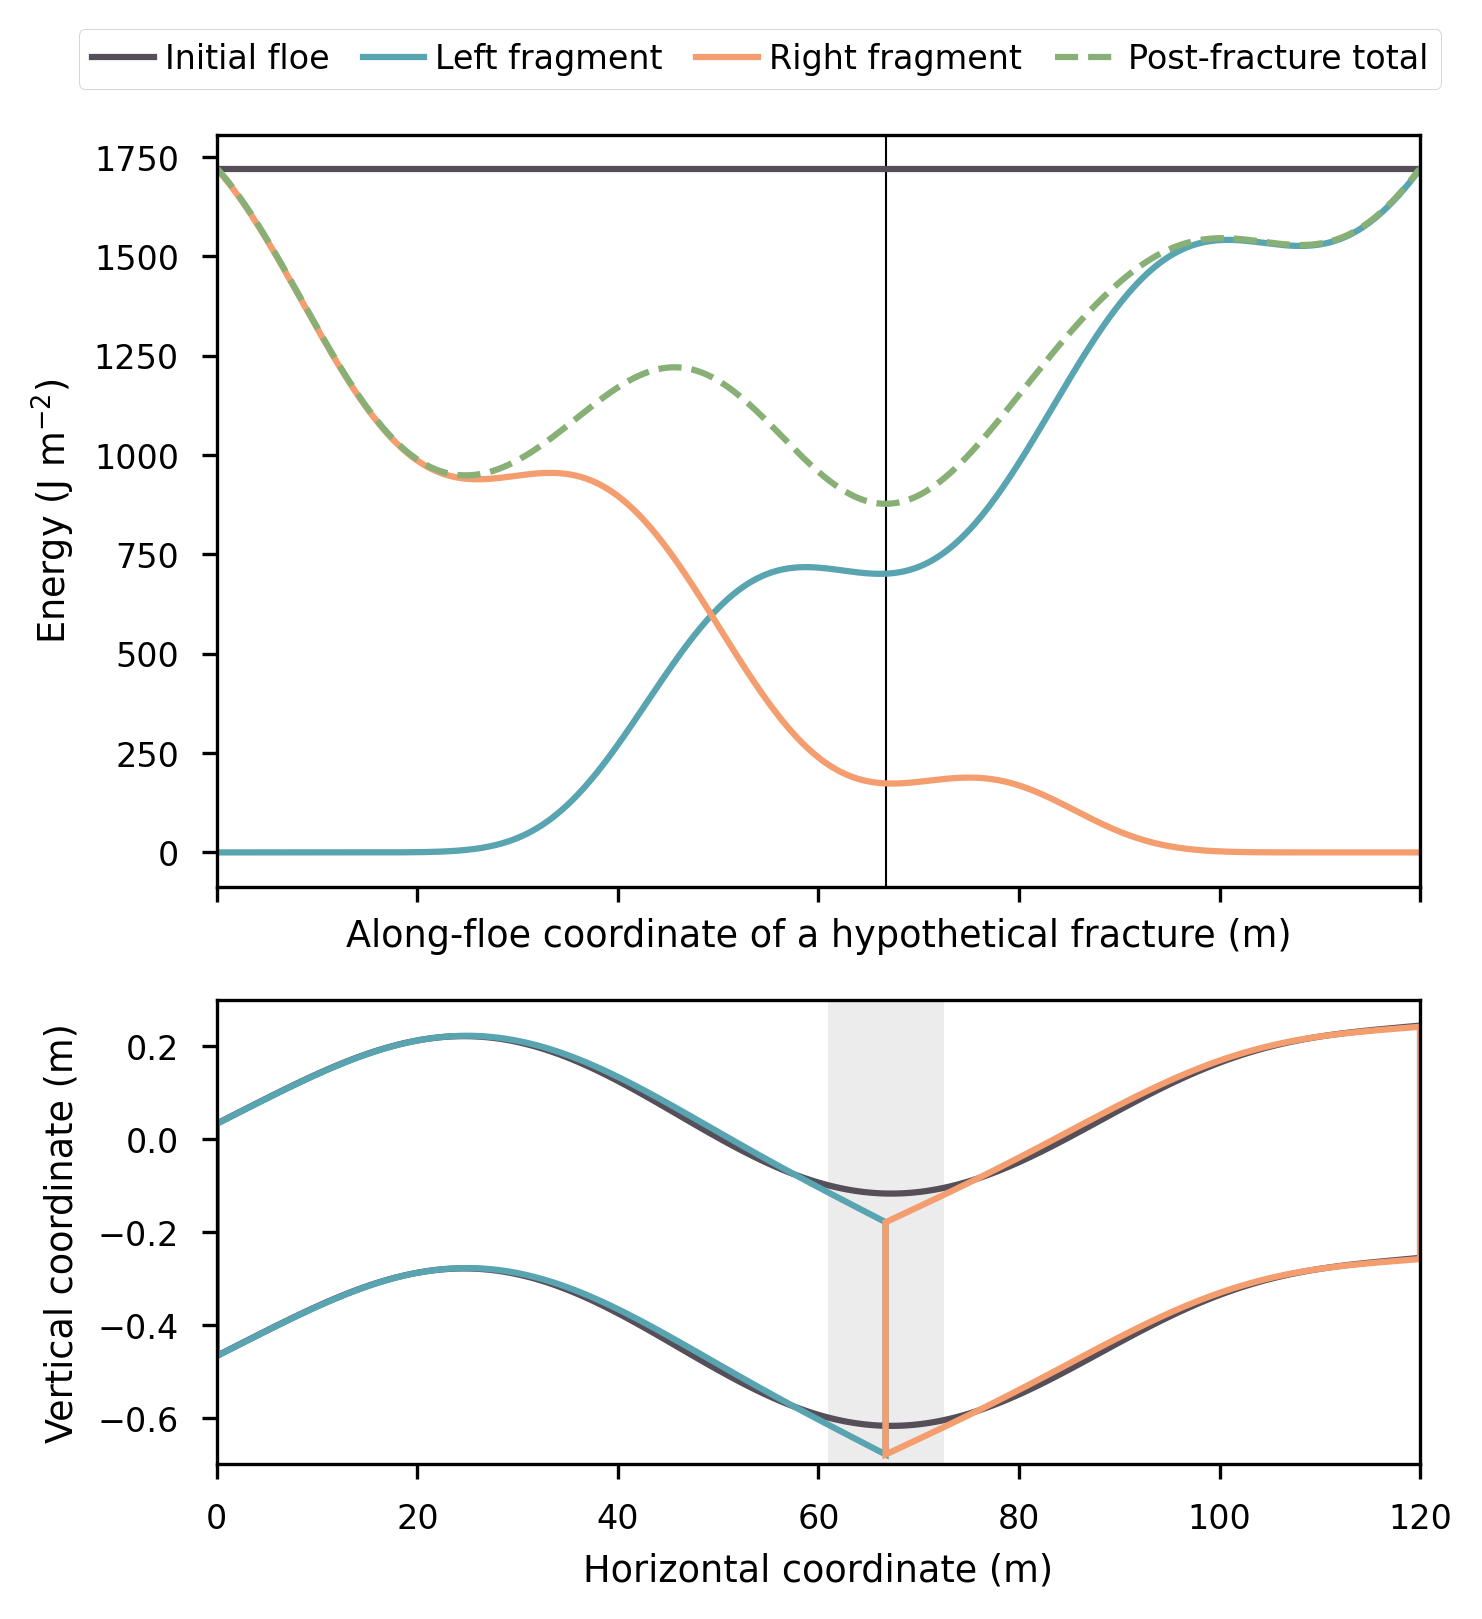

In [9]:
lw = 1.5

colours = "#58A4B0", "#F49D6E", "#88b076", "#564E58",

deflected_floe = plt.Polygon(
    np.vstack((
        np.hstack((along_floe_axis, along_floe_axis[::-1])),
        np.hstack((deflected_floe_top, deflected_floe_bottom[::-1]))
    )).T,
    closed=True,
    facecolor="#0000",
    edgecolor=colours[3],
    lw=lw,
)

postf_deflected_floes = [
    plt.Polygon(
        np.vstack((
            np.hstack((_x, _x[::-1])),
            np.hstack((_df_top, _df_bottom[::-1]))
        )).T,
        closed=True,
        facecolor="#0000",
        edgecolor=_c,
        lw=lw,
    )
    for _x, _df_top, _df_bottom, label, _c in zip(
        postf_along_floe_axes,
        postf_deflected_floe_tops,
        postf_deflected_floe_bottoms,
        ("Left fragment", "Right fragment"),
        colours[:2],
    )
]


width = 0.8 * WIDTH_SINGLE_COLUMN
height = width / .9792

with plt.style.context("seaborn-v0_8-paper"), sns.color_palette(colours):
    fig, axes = plt.subplots(2, dpi=300, figsize=(width, height), sharex=True, height_ratios=(1, 1 / GR))

    ax = axes[0]
    ax.axhline(diagnostic.initial_energy[0], label="Initial floe", c="C3", lw=lw)
    ax.plot(diagnostic.x, diagnostic.energy[:, 0], lw=lw, label="Left fragment")
    ax.plot(diagnostic.x, diagnostic.energy[:, 1], lw=lw, label="Right fragment")
    ax.axvline(xf, lw=.5, zorder=-10, c="k")
    ax.plot(
        diagnostic.x,
        diagnostic.energy.sum(axis=1) + diagnostic.frac_energy_rate,
        label="Post-fracture total",
        ls="--",
        lw=lw,
    )

    ax.set_xlabel("Along-floe coordinate of a hypothetical fracture (m)")
    ax.set_ylabel("Energy (J m$^{-2}$)")

    ax.set_xlim(wuf.left_edge, wuf.left_edge + wuf.length)

    ax = axes[1]
    for patch in (deflected_floe, *postf_deflected_floes):
        ax.add_patch(patch)

    lb, ub = (
        xf + np.array((-relaxation_length, relaxation_length)) / 2
    )
    ax.axvspan(lb, ub, alpha=.1, facecolor="C3", zorder=-10)
    
    ax.set_xlim(wuf.left_edge, wuf.length)
    ax.set_ylim(-.7, .3)

    ax.set_xlabel("Horizontal coordinate (m)")
    ax.set_ylabel("Vertical coordinate (m)")


    fig.legend(
        ncols=4,
        handlelength=1.85,
        loc="upper center",
        bbox_to_anchor=(
            (axes[0].bbox.x0 + axes[0].bbox.x1) / 2 / fig.bbox.width,
            1.05
        ),
        handletextpad=.33,
        columnspacing=1,
    )
    
    fig.tight_layout()

    print([ax.bbox.width / ax.bbox.height for ax in axes])
    # fig.savefig("fracture_search.pdf", dpi=fig.dpi, bbox_inches="tight")

    plt.show()
    plt.close()

# Schema strain fracture

In [10]:
strain_fh = BinaryStrainFracture()
strain_diagnosis = strain_fh.diagnose(wuf, res=.1, an_sol=True)

strain_exceeds_threshold = np.nonzero(np.abs(strain_diagnosis.strain) > ice.strain_threshold)[0]
exceeding_strain_boundaries = np.vstack((
    np.hstack((
        strain_exceeds_threshold[0],
        strain_exceeds_threshold[np.nonzero(np.ediff1d(strain_exceeds_threshold) > 1)[0] + 1]
    )),
    np.hstack((
        strain_exceeds_threshold[np.nonzero(np.ediff1d(strain_exceeds_threshold) > 1)[0]],
        strain_exceeds_threshold[-1]))
)).T
strain_xf = strain_fh.search(wuf, None, True, None)

In [164]:
np.savez(
    "strain_diagnostic.npz",
    x=strain_diagnosis.x,
    strain=strain_diagnosis.strain,
    peaks=strain_diagnosis.peaks,
    extrema=strain_diagnosis.strain_extrema,
)

strain_dict = dict(
    threshold=ice.strain_threshold,
    xf=strain_xf,
)
with open("strain_values.json", "w") as f:
    json.dump(strain_dict, f)

1.6182625254447642


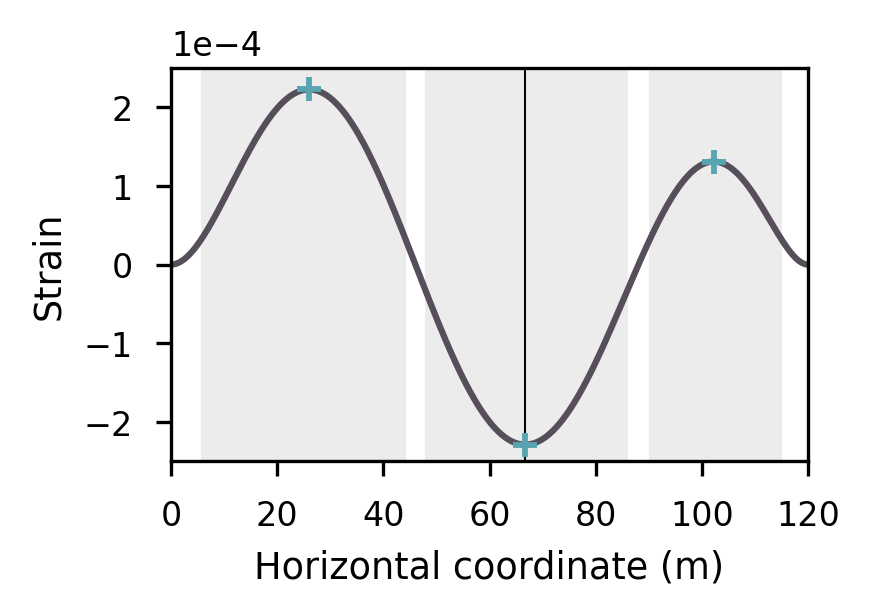

In [11]:
with plt.style.context("seaborn-v0_8-paper"), sns.color_palette(colours):
    width = WIDTH_TWO_COLUMNS
    height = WIDTH_TWO_COLUMNS / GR / .86
    fig, ax = plt.subplots(dpi=300, figsize=(width, height))
    
    ax.plot(strain_diagnosis.x, strain_diagnosis.strain, "C3", lw=lw, alpha=1)
    ax.scatter(
        strain_diagnosis.peaks, strain_diagnosis.strain_extrema, c="C4", marker="+", alpha=1,
        zorder=10,
    )
    ax.axvline(strain_xf, zorder=-10, c="k", lw=.5)
    
    for _p in exceeding_strain_boundaries:
        ax.axvspan(*strain_diagnosis.x[_p], facecolor="C3", alpha=.1)
    
    ax.set_xlim(wuf.left_edge, wuf.left_edge + wuf.length)
    ax.set_ylim(-2.5e-4, 2.5e-4)
    ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))

    ax.set_xlabel("Horizontal coordinate (m)")
    ax.set_ylabel("Strain")
    
    fig.tight_layout()

    print(ax.bbox.width / ax.bbox.height)
    # fig.savefig("strain_fracture.pdf", dpi=fig.dpi, bbox_inches="tight")
    
    plt.show()
    plt.close()

# Rayleigh wave speed

In [12]:
youngs_modulus, poissons_ratio = ice.youngs_modulus / 1, ice.poissons_ratio
print(f"{youngs_modulus:g}", poissons_ratio)
lam, mu = youngs_modulus * poissons_ratio / (1 - poissons_ratio**2), youngs_modulus / (2 * (1 + poissons_ratio))
print(lam, mu)

beta_pow2 = mu / ice.density
alpha_pow2 = (lam + 2 * mu) / ice.density
eta = beta_pow2 / alpha_pow2
print(alpha_pow2, beta_pow2, eta)

roots = np.polynomial.polynomial.polyroots((
    -16 * (1 - eta),
    8 * (3 - 2 * eta),
    -8,
    1
))
print(roots)
speeds = (roots * beta_pow2)**.5
print(speeds)

4e+09 0.3
1318681318.6813185 1538461538.4615383
4764882.813663301 1667708.9847821554 0.35
[0.83944857 2.92507432 4.23547711]
[1183.19733293 2208.65858084 2657.73272225]


In [13]:
f"{ice.thickness / speeds.min():e}"

'4.225838e-04'

In [14]:
# approximation from S-wave speed
(.862 + 1.14 * poissons_ratio) / (1 + poissons_ratio) * np.sqrt(mu / ice.density)

1196.0332928822766

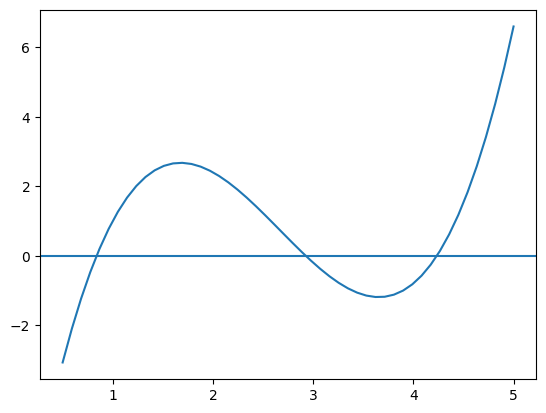

In [15]:
_zetas = np.linspace(.5, 5)
poly = _zetas**3 - 8 * _zetas**2 + 8 * (3 - 2 * eta) * _zetas - 16 * (1 - eta)
plt.plot(_zetas, poly)
plt.axhline(0)
plt.show()
plt.close()

In [16]:
_t = roots**2 / beta_pow2
_t**3 - 8 * _t**2 + 8 * _t * (3 - 2 * eta) - 16 * (1 - eta)

array([-10.39999223, -10.3999056 , -10.39980208])

# Seismic waves speeds

In [17]:
# https://fr.wikipedia.org/wiki/Onde_sismique
vp = np.sqrt((lam + 2 * mu) / ice.density)
vs = np.sqrt(mu / ice.density)
vp, vs

(2182.861153088602, 1291.3980737100994)